In [1]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

# Генерация данных

In [2]:
def generate_x_y_data_two_freqs(isTrain , batch_size , seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        )
        
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        ) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
        
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # размерность: (batch_size , seq_length , output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # размерность: (seq_length , batch_size , output_dim)

    return batch_x , batch_y



In [3]:
def generate_x_y_data_v2( isTrain , batch_size ):
    return generate_x_y_data_two_freqs( isTrain , batch_size , seq_length=15)

# Определение параметров нейросети

In [4]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = generate_x_y_data_v2(isTrain=True , batch_size=3)

# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 120
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 70
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 2

# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.007
# Количество итераций по обучающей выборке 
nb_iters = 2800
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.8
momentum = 0.3
# Коэффициент L2 регуляризации
lambda_l2_reg = 1e-12

# Описание графа вычислений

In [5]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

tf.reset_default_graph()

sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32,shape = (None,input_dim),name = "inp_{}".format(t))
            for t in range (seq_length)
    ]
    
    expected_sparse_output = [
        tf. placeholder (tf.float32,shape = (None,output_dim),name = "expected_sparse_output_".format(t))
            for t in range (seq_length)
    ]
    
    dec_inp = [tf.zeros_like(enc_inp[0],dtype = np.float32,name ="GO")] + enc_inp[: -1]
    
    cells = []
    for i in range (layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            
    w_in = tf.Variable(tf.random_normal([input_dim,hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim],mean = 1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim,output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i,w_in) + b_in) for i in enc_inp]
    
    dec_outputs,dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )
    
    output_scale_factor = tf.Variable(1.0,name = "Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i,w_out) + b_out) for i in dec_outputs]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argu

# Описание функции потерь и оптимизатора

In [6]:
#Функция потерь
with tf.variable_scope('Loss'):
    output_loss = 0
    for _y,_Y in zip(reshaped_outputs,expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    
    loss = output_loss + lambda_l2_reg * reg_loss

In [7]:
#Оптимизатор
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate,decay = lr_decay,momentum = momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Обучение и валидация нейронной сети

In [8]:
def train_batch(batch_size):
    X,Y = generate_x_y_data_v2(isTrain = True,batch_size = batch_size)
    feed_dict = {enc_inp[t]:X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]:Y[t] for t in range (len(expected_sparse_output))})
    _, loss_t = sess.run([train_op,loss],feed_dict)
    return loss_t


In [9]:
def test_batch(batch_size):
    X,Y = generate_x_y_data_v2(isTrain = False,batch_size = batch_size)
    feed_dict = {enc_inp[t]:X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]:Y[t] for t in range (len(expected_sparse_output))})
    loss_t = sess.run([loss],feed_dict)
    return loss_t [0]

In [10]:
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range (nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses . append (train_loss)
    
    if t % 10 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step{}/{},train loss:{},\tTEST loss:{}".format(t,nb_iters,train_loss,test_loss))

print("Fin.train loss:{},\tTEST loss:{}".format(train_loss,test_loss))

Step0/2800,train loss:689.9326782226562,	TEST loss:10422.5576171875
Step10/2800,train loss:431.0517578125,	TEST loss:447.203857421875
Step20/2800,train loss:454.4980163574219,	TEST loss:465.282958984375
Step30/2800,train loss:424.25830078125,	TEST loss:465.5235900878906
Step40/2800,train loss:416.791259765625,	TEST loss:436.71142578125
Step50/2800,train loss:374.4185791015625,	TEST loss:403.69781494140625
Step60/2800,train loss:410.1269836425781,	TEST loss:428.0050048828125
Step70/2800,train loss:417.80938720703125,	TEST loss:428.0710144042969
Step80/2800,train loss:381.3382873535156,	TEST loss:352.7882995605469
Step90/2800,train loss:395.06976318359375,	TEST loss:375.9037170410156
Step100/2800,train loss:400.3947448730469,	TEST loss:375.7400207519531
Step110/2800,train loss:358.52960205078125,	TEST loss:430.984619140625
Step120/2800,train loss:352.31390380859375,	TEST loss:368.121337890625
Step130/2800,train loss:340.8118896484375,	TEST loss:362.9479675292969
Step140/2800,train loss:3

Step1150/2800,train loss:101.93414306640625,	TEST loss:83.62528991699219
Step1160/2800,train loss:86.01461791992188,	TEST loss:100.40908813476562
Step1170/2800,train loss:88.01593780517578,	TEST loss:100.17804718017578
Step1180/2800,train loss:96.6334228515625,	TEST loss:90.95368957519531
Step1190/2800,train loss:101.47149658203125,	TEST loss:105.59388732910156
Step1200/2800,train loss:123.65887451171875,	TEST loss:104.79010009765625
Step1210/2800,train loss:104.62063598632812,	TEST loss:123.02043151855469
Step1220/2800,train loss:84.72478485107422,	TEST loss:111.55091094970703
Step1230/2800,train loss:97.67890167236328,	TEST loss:85.40345764160156
Step1240/2800,train loss:80.935546875,	TEST loss:127.56719970703125
Step1250/2800,train loss:73.6406478881836,	TEST loss:88.12633514404297
Step1260/2800,train loss:95.25621032714844,	TEST loss:112.77986145019531
Step1270/2800,train loss:90.69005584716797,	TEST loss:104.63158416748047
Step1280/2800,train loss:74.15863037109375,	TEST loss:88.5

Step2290/2800,train loss:75.26518249511719,	TEST loss:125.66494750976562
Step2300/2800,train loss:58.500511169433594,	TEST loss:68.18435668945312
Step2310/2800,train loss:66.54833984375,	TEST loss:80.27471160888672
Step2320/2800,train loss:59.482017517089844,	TEST loss:53.74857711791992
Step2330/2800,train loss:55.82011413574219,	TEST loss:86.06517791748047
Step2340/2800,train loss:68.05443572998047,	TEST loss:54.67259216308594
Step2350/2800,train loss:56.64775848388672,	TEST loss:56.60906982421875
Step2360/2800,train loss:92.35395812988281,	TEST loss:61.603389739990234
Step2370/2800,train loss:60.75446319580078,	TEST loss:75.33792114257812
Step2380/2800,train loss:88.81326293945312,	TEST loss:102.63153076171875
Step2390/2800,train loss:101.36015319824219,	TEST loss:75.14073944091797
Step2400/2800,train loss:68.19335174560547,	TEST loss:88.681640625
Step2410/2800,train loss:71.11212158203125,	TEST loss:61.77803039550781
Step2420/2800,train loss:57.39788055419922,	TEST loss:65.366569519

# Визуализация результатов

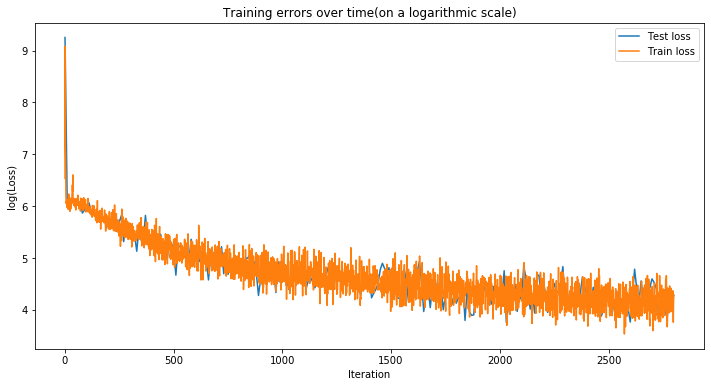

In [11]:
#Визуализация процесса обучения
plt.figure(figsize = (12,6))
plt.plot(
    np.array(range (0,len(test_losses))) / float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),
    label = "Test loss"
)

plt.plot(
    np.log(train_losses),
    label = "Train loss"
)

plt.title("Training errors over time(on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc = 'best')
plt.show()

Let's visualize1 predictions with our signals:


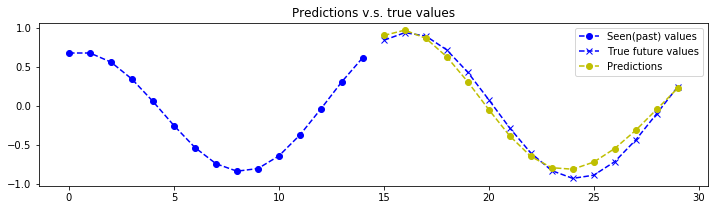

In [12]:
nb_predictions = 1
print ("Let's visualize{} predictions with our signals:".format(nb_predictions))

X,Y = generate_x_y_data_v2(isTrain = False,batch_size = nb_predictions)
feed_dict = {enc_inp[t]:X[t] for t in range (seq_length)}
outputs = np.array(sess.run([reshaped_outputs],feed_dict)[0])

for j in range(nb_predictions):
    plt.figure(figsize = (12,3))
    
    for k in range(output_dim):
        past = X [:,j,k]
        expected = Y [:,j,k]
        pred = outputs [:,j,k]
        
    label1 = "Seen(past) values" if k == 0 else "_nolegend_"
    label2 = "True future values" if k == 0 else "_nolegend_"
    label3 = "Predictions" if k == 0 else "_nolegend_"
    plt.plot(range(len(past)),past,"o--b",label = label1)
    plt.plot(range(len(past),len ( expected )+ len(past)),expected,"x--b",label = label2)
    plt.plot(range(len(past),len ( pred )+ len(past)),pred,"o--y",label = label3)
    
    plt.legend(loc = 'best')
    plt.title("Predictions v.s. true values")
    plt.show()